# Home Credit Default Risk
This NOTEBOOK will provide an introduction to the process of creating forecast results and the basic methodology.

First, let's review the task we will be performing (see README.ipynb for details).

Objective: To predict the probability of default based on customer data.

Evaluation index: Area Under the Curve (AUC)

## Contents
0. Loading libraries and the data
1. Data visualization and analysis
2. Preprocessing and feature creation
3. Machine learning model creation
4. Creating prediction results

## 0. Loading libraries and the data

Let's load basic libraries.
Other required libraries will be loaded when we explain them.
- numpy: Library for efficient numerical computation
- pandas: Library useful for data analysis
- matplotlib: Graph drawing library
- seaborn: Graph drawing library as well

In [1]:
# Loading libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
from pathlib import Path

# Automatically get the current working directory
current_dir = Path(os.getcwd())

# Define file paths using pathlib
train_file = current_dir / "input" / "train.csv"
test_file = current_dir / "input" / "test.csv"
sample_sub_file = current_dir / "input" / "sample_submission.csv"

# Load data
train = pd.read_csv(train_file)
test = pd.read_csv(test_file)
sample_sub = pd.read_csv(sample_sub_file)

## 1. Data visualization and analysis

### 1.1 Data Overview
Before conducting a full-scale analysis, we will first review a brief overview of the data.

In [3]:
# Check train data
print(f"train shape: {train.shape}")
train.head(3)

train shape: (171202, 34)


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER  CNT_CHILDREN  AMT_INCOME_TOTAL  \
0           0         Cash loans           F             0          112500.0   
1           1         Cash loans           F             0          225000.0   
2           2         Cash loans           F             0           54000.0   

   AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE NAME_INCOME_TYPE  \
0    755190.0      36328.5         675000.0          Working   
1    585000.0      16893.0         585000.0        Pensioner   
2    334152.0      18256.5         270000.0    State servant   

             NAME_EDUCATION_TYPE  ... ORGANIZATION_TYPE EXT_SOURCE_1  \
0               Higher education  ...            School          NaN   
1  Secondary / secondary special  ...               XNA          NaN   
2  Secondary / secondary special  ...            Postal          NaN   

   EXT_SOURCE_2  EXT_SOURCE_3  DAYS_LAST_PHONE_CHANGE  \
0      0.372591           NaN                  -292.0   
1      0.449567      0.553165                  -617.0   
2      0.569503           NaN                  -542.0   

   AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_MON  \
0                         NaN                        NaN   
1                         0.0                        0.0   
2                         NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  TARGET  
0                        NaN                         NaN       0  
1                        0.0                         1.0       0  
2                        NaN                         NaN       0  

[3 rows x 34 columns]

In [4]:
# Check test data
print(f"test shape: {test.shape}")
test.head(3)

test shape: (61500, 33)


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER  CNT_CHILDREN  AMT_INCOME_TOTAL  \
0      171202         Cash loans           F             1          144000.0   
1      171203         Cash loans           F             0          103500.0   
2      171204         Cash loans           F             1          180000.0   

   AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE      NAME_INCOME_TYPE  \
0    961146.0      28233.0         688500.0               Working   
1    296280.0      16069.5         225000.0               Working   
2    183694.5      11236.5         139500.0  Commercial associate   

             NAME_EDUCATION_TYPE  ... REGION_RATING_CLIENT ORGANIZATION_TYPE  \
0               Higher education  ...                    2      Kindergarten   
1  Secondary / secondary special  ...                    2            School   
2  Secondary / secondary special  ...                    3     Trade: type 7   

   EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_LAST_PHONE_CHANGE  \
0           NaN      0.720416           NaN                    -1.0   
1           NaN      0.287306           NaN                  -212.0   
2           NaN      0.352456      0.389339                  -428.0   

   AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_MON  \
0                         NaN                        NaN   
1                         NaN                        NaN   
2                         0.0                        1.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        NaN                         NaN  
1                        NaN                         NaN  
2                        1.0                         1.0  

[3 rows x 33 columns]

You can see that there are 30 types of features. In this notebook, we will not analyze all 30 types of features, but will focus on 5 types of features. When the number of features is large, as in this case, it would be difficult to perform analysis and preprocessing on all the features from the beginning. Therefore, it is easier to start with a small number of features with the goal of producing prediction results, and then increase the number of features to be handled. For the remaining 25 types of features, please refer to the previous materials and this NOTEBOOK, etc., and perform the analysis on your own.


For the 5 types of features used, we have selected them so that we can explain the various processes.

In [5]:
# Focus on 5 features
use_features = ["NAME_CONTRACT_TYPE", "AMT_INCOME_TOTAL", "EXT_SOURCE_2", "OWN_CAR_AGE", "ORGANIZATION_TYPE"]
target = train["TARGET"].values

train = train[use_features]
train["TARGET"] = target
test = test[use_features]

Let's check the data once again.

In [6]:
# Check train data
print(f"train shape: {train.shape}")
train.head(3)

train shape: (171202, 6)


NAME_CONTRACT_TYPE  AMT_INCOME_TOTAL  EXT_SOURCE_2  OWN_CAR_AGE  \
0         Cash loans          112500.0      0.372591          NaN   
1         Cash loans          225000.0      0.449567          NaN   
2         Cash loans           54000.0      0.569503          NaN   

  ORGANIZATION_TYPE  TARGET  
0            School       0  
1               XNA       0  
2            Postal       0

In [7]:
# Check test data
print(f"test shape: {test.shape}")
test.head(3)

test shape: (61500, 5)


NAME_CONTRACT_TYPE  AMT_INCOME_TOTAL  EXT_SOURCE_2  OWN_CAR_AGE  \
0         Cash loans          144000.0      0.720416          NaN   
1         Cash loans          103500.0      0.287306          NaN   
2         Cash loans          180000.0      0.352456          NaN   

  ORGANIZATION_TYPE  
0      Kindergarten  
1            School  
2     Trade: type 7

### 1.2 Visualization and analysis(EDA)
Next, we will visualize and analyze the data. In this work, we deepen our understanding of the data by checking the distribution of feature values, missing values, outliers, correlations, and so on. The results of the analysis obtained at this stage are used for preprocessing, feature creation, and selection of machine learning models, which are important tasks that will greatly affect the final forecast.

#### 1.2.1 Checking missing values
In this section, we check for missing values.
Most machine learning models cannot be trained on data with missing values. Therefore, we must fill in the missing values with some value, so we always check for missing values.

In [8]:
# Check missing values of train data
train.isnull().sum()

NAME_CONTRACT_TYPE         0
AMT_INCOME_TOTAL           0
EXT_SOURCE_2             369
OWN_CAR_AGE           112992
ORGANIZATION_TYPE          0
TARGET                     0
dtype: int64

In [9]:
# Check missing values of test data
test.isnull().sum()

NAME_CONTRACT_TYPE        0
AMT_INCOME_TOTAL          0
EXT_SOURCE_2            130
OWN_CAR_AGE           40909
ORGANIZATION_TYPE         0
dtype: int64

We found that there are missing values in EXT_SOURCE_2 and OWN_CAR_AGE. We will deal with these missing values later. Of course, there is a possibility that there are missing values for other features that we are not covering here, so please check them by yourself.

#### 1.2.2 Visualization and analysis of each feature
In this section, each feature is visualized and analyzed to see what kind of characteristics it has.

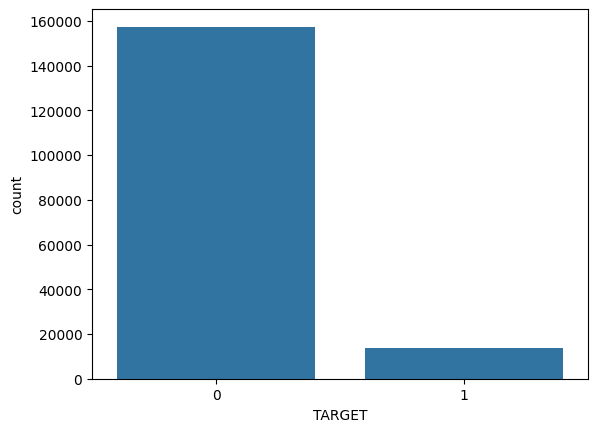

In [10]:
# The distribution of the target (default or not)
sns.countplot(data=train, x="TARGET")
plt.show()

We can see that the distribution of the objective variable is highly skewed. Data in which the distribution of the objective variable is highly skewed in this way is called unbalanced data.


When dealing with unbalanced data, we need to be particularly careful in selecting evaluation indices. For example, if you choose the correct response rate (Accuracy) as the evaluation indicator this time, you will find that simply predicting all zeros will result in a high correct response rate. Choosing such an inappropriate metric can cause the machine learning model to fail to learn well.

Another approach to dealing with unbalanced data is to try to balance the distribution of the objective variable. The method of reducing the data of the larger objective variable is called undersampling, while the method of increasing the data of the smaller objective variable is called oversampling.

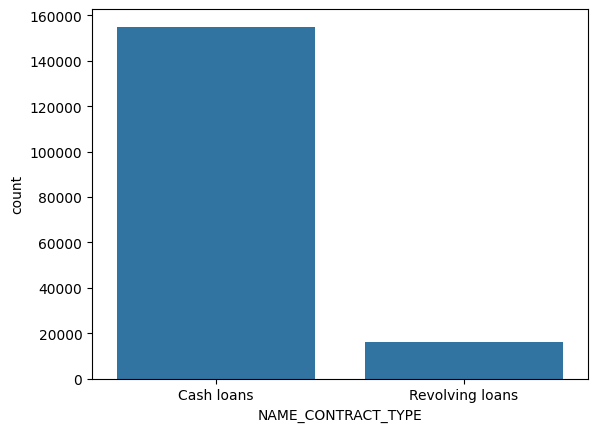

In [11]:
# The distribution of NAME_CONTRACT_TYPE
sns.countplot(data=train, x="NAME_CONTRACT_TYPE")
plt.show()

There are two variables in NAME_CONTRACT_TYPE, Cash loans and Revolving loans, but they are not evenly distributed. Also, since the machine learning model can only handle data of numeric type, it is necessary to convert the data from string type to numeric type.

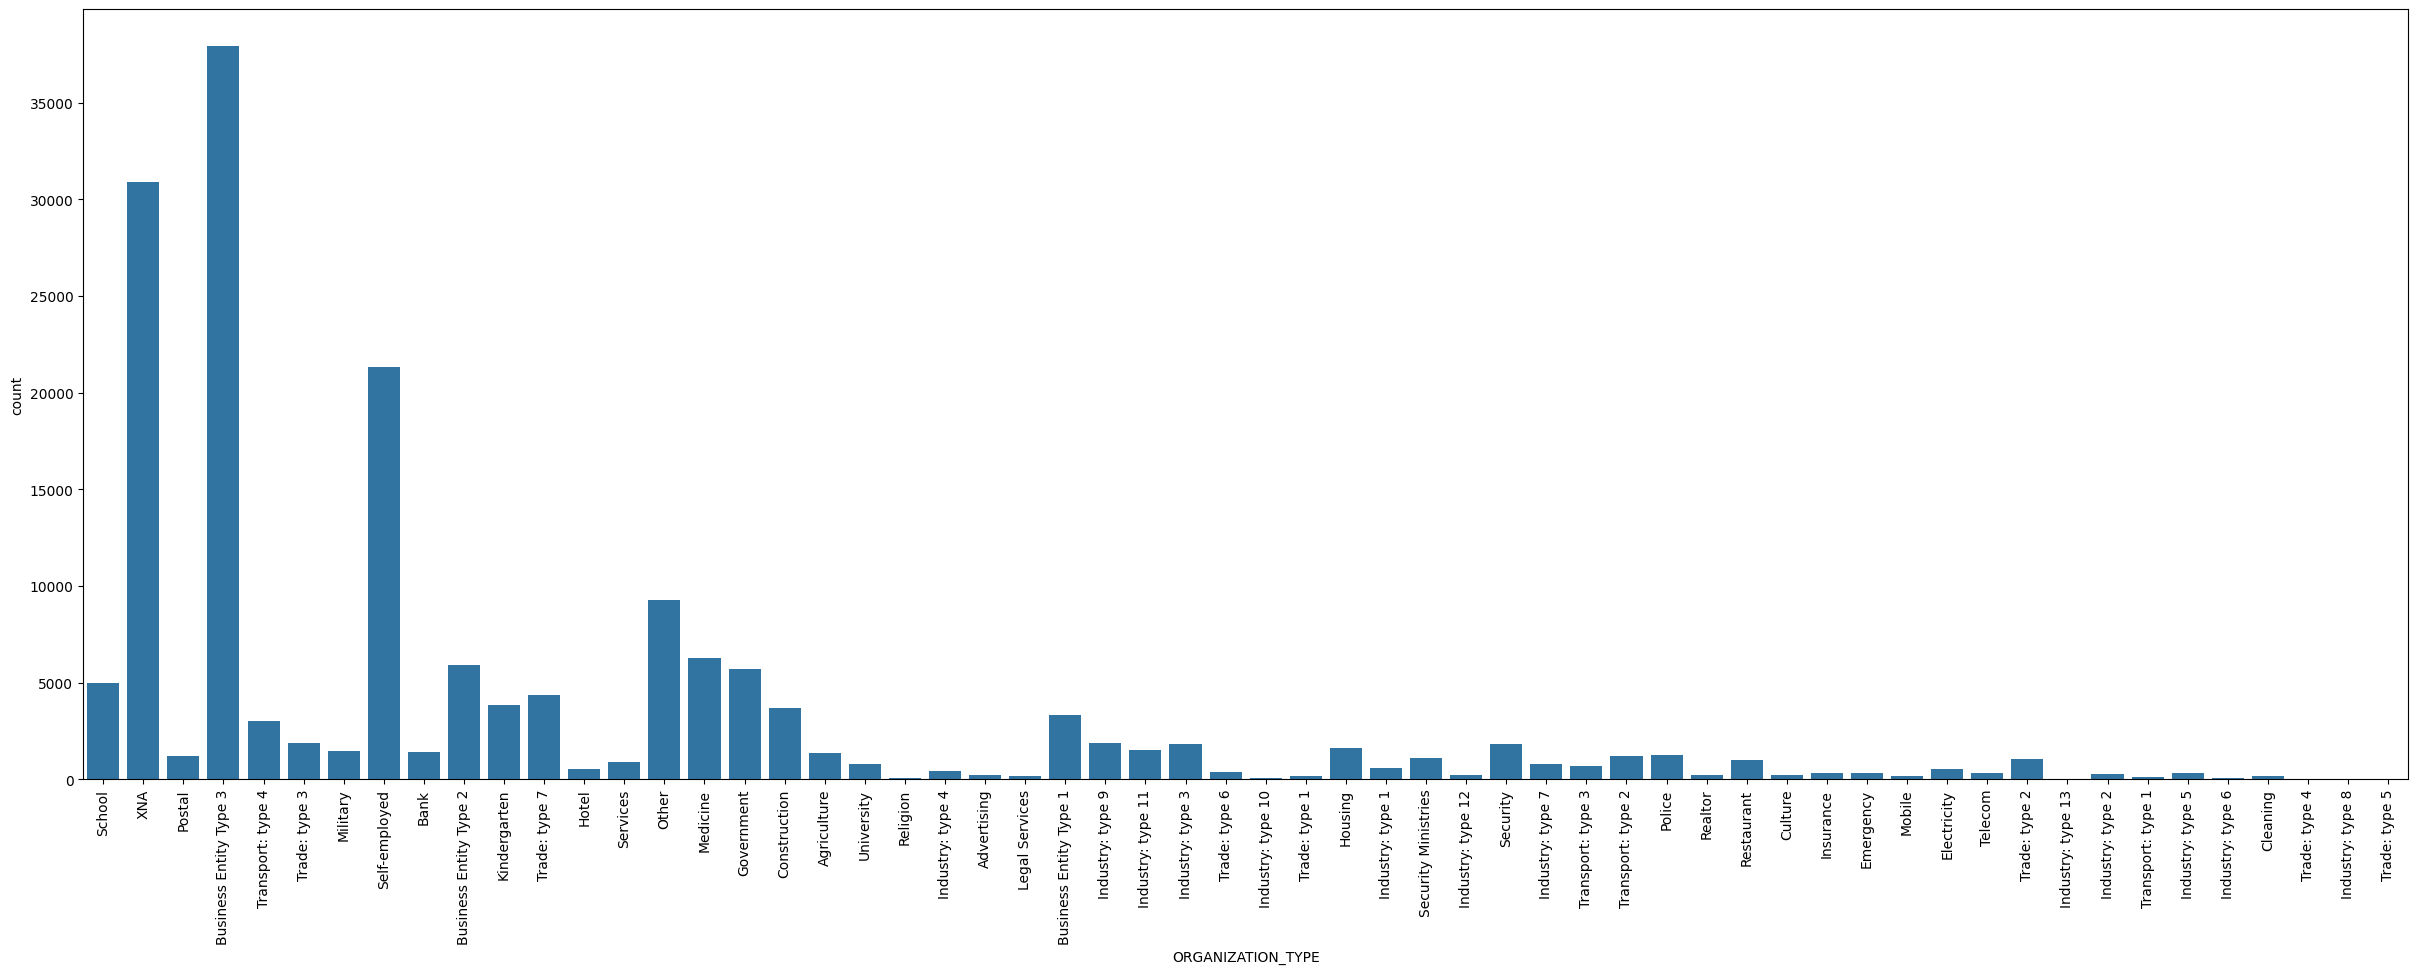

In [12]:
# The distribution of ORGANIZATION_TYPE
plt.figure(figsize=(30, 10))
sns.countplot(data=train, x="ORGANIZATION_TYPE")
plt.tick_params(axis="x", rotation=90)
plt.show()

There are many different ORGANIZATION_TYPEs, and you can also see that there is an ununiformity in the number of data. This is also a string type feature, so it needs to be converted to a numeric type. Also, the second variable from the left is “XNA,” which we can infer from its name to be a missing value.


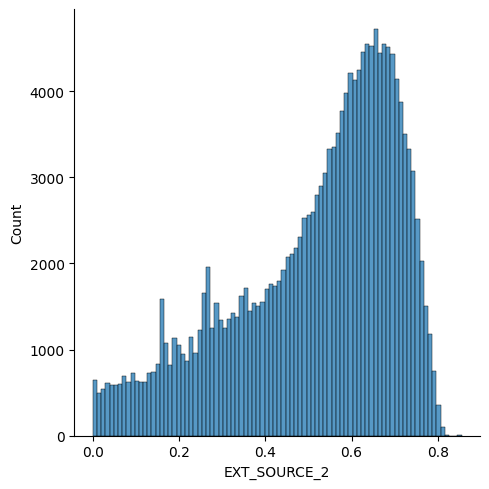

In [13]:
# The distribution of EXT_SOURCE_2
sns.displot(data=train, x="EXT_SOURCE_2")
plt.show()

We can see that EXT_SOURCE_2 is normalized between 0 and 1. It seems we can handle this feature as it is.

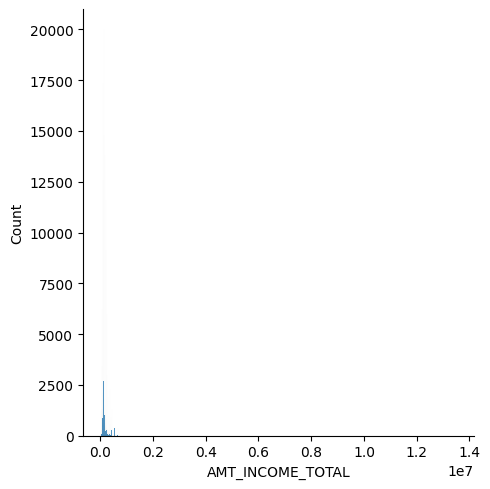

In [14]:
# The distribution of AMT_INCOME_TOTAL
sns.displot(data=train, x="AMT_INCOME_TOTAL")
plt.show()

AMT_INCOME_TOTAL does not graph well when visualized as usual. In such cases, the cause may be the presence of a small number of outliers that take large values. If you wish to visualize data like this, a logarithmic transformation can be performed to successfully display the graph.

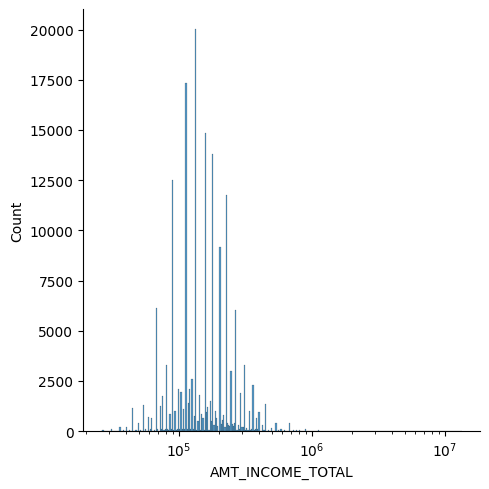

In [15]:
# The distribution of AMT_INCOME_TOTAL（Logarithmic transformation）
sns.displot(data=train, x="AMT_INCOME_TOTAL", log_scale=10)
plt.show()

We displayed the graph successfully by using logarithmic transformation.
The income is supposed to be a continuous value, but it looks like a discrete value. Let's have a look at the type of AMT_INCOME_TOTAL values.

In [16]:
# Check the type of AMT_INCOME_TOTAL values
len(train["AMT_INCOME_TOTAL"].unique())

1641

There are 171202 data in train, but AMT_INCOME_TOTAL consists of only 1641 different values. Let's check the top 10 values specifically.

In [17]:
# Top 10 values of AMT_INCOME_TOTAL
train["AMT_INCOME_TOTAL"].value_counts().head(10)

AMT_INCOME_TOTAL
135000.0    19969
112500.0    17320
157500.0    14772
180000.0    13791
90000.0     12481
225000.0    11573
202500.0     9128
67500.0      6130
270000.0     6006
81000.0      3295
Name: count, dtype: int64

It appears that AMT_INCOME_TOTAL is not an exact annual income, but rather data compiled from a rounded number.

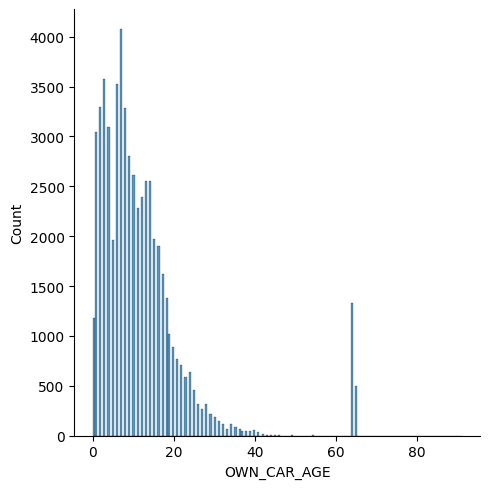

In [18]:
# The distribution of OWN_CAR_AGE
sns.displot(data=train, x="OWN_CAR_AGE")
plt.show()

OWN_CAR_AGE can be inferred to be in years from the scale of values. In addition, the distribution is natural from 0 to 40, but there is an unnatural distribution around 60 to 70. It is hard to imagine that the number of years a car has been purchased increases suddenly like this, so they are considered to be outliers.

Up to this point, we have visualized and analyzed each feature. I believe that you have realized that visualization requires some ingenuity and that visualization can deepen your understanding of data. I am sure that the visualization and analysis of the 25 features not covered here will lead to improved forecasting accuracy.

## 2. Preprocessing and feature creation
Here, we will conduct the preprocessing and create new features based on what we have learned in the preceding visualization and analysis.

Complete missing values in EXT_SOURCE_2. There are various methods for completing missing values, but in this case, since the number of missing values is small, we simply use the average value to complete the missing values.

In [19]:
# Complete missing values of EXT_SOURCE_2 with the average
train["EXT_SOURCE_2"].fillna(train["EXT_SOURCE_2"].mean(), inplace=True)
test["EXT_SOURCE_2"].fillna(train["EXT_SOURCE_2"].mean(), inplace=True)

train.isnull().sum()

NAME_CONTRACT_TYPE         0
AMT_INCOME_TOTAL           0
EXT_SOURCE_2               0
OWN_CAR_AGE           112992
ORGANIZATION_TYPE          0
TARGET                     0
dtype: int64

Convert NAME_CONTRACT_TYPE to a numeric type. In this case, “Cash loans” is converted to 0 and “Revolving loans” to 1. This method of simply replacing an integer is called Label Encoding.

In [20]:
# Numerization of NAME_CONTRACT_TYPE（Label Encoding）
train["NAME_CONTRACT_TYPE"].replace({'Cash loans': 0, 'Revolving loans': 1}, inplace=True)
test["NAME_CONTRACT_TYPE"].replace({'Cash loans': 0, 'Revolving loans': 1}, inplace=True)

train.head(5)

NAME_CONTRACT_TYPE  AMT_INCOME_TOTAL  EXT_SOURCE_2  OWN_CAR_AGE  \
0                   0          112500.0      0.372591          NaN   
1                   0          225000.0      0.449567          NaN   
2                   0           54000.0      0.569503          NaN   
3                   0           67500.0      0.105235          NaN   
4                   0          157500.0      0.202490          NaN   

        ORGANIZATION_TYPE  TARGET  
0                  School       0  
1                     XNA       0  
2                  Postal       0  
3                     XNA       0  
4  Business Entity Type 3       1

Convert ORGANIZATION_TYPE to a numeric type. This time, we will convert the variable to numeric in terms of the number of data in the variable. For example, if the number of data in “Police” is 1279 and the number of data in “Bank” is 1385, convert “Police” to 1279 and “Bank” to 1385. This method of replacing the number of data with the number of data is called Count Encoding.

In [21]:
# Numerization of ORGANIZATION_TYPE (Count Encoding）
organization_ce = train["ORGANIZATION_TYPE"].value_counts()
train["ORGANIZATION_TYPE"] = train["ORGANIZATION_TYPE"].map(organization_ce)
test["ORGANIZATION_TYPE"] = test["ORGANIZATION_TYPE"].map(organization_ce)

train.head(5)

NAME_CONTRACT_TYPE  AMT_INCOME_TOTAL  EXT_SOURCE_2  OWN_CAR_AGE  \
0                   0          112500.0      0.372591          NaN   
1                   0          225000.0      0.449567          NaN   
2                   0           54000.0      0.569503          NaN   
3                   0           67500.0      0.105235          NaN   
4                   0          157500.0      0.202490          NaN   

   ORGANIZATION_TYPE  TARGET  
0               4991       0  
1              30898       0  
2               1185       0  
3              30898       0  
4              37943       1

Let's deal with OWN_CAR_AGE. First, we will replace the unnatural outliers that are over 60 with missing values.

In [22]:
# Treat values above 60 (outliers) in OWN_CAR_AGE as missing values.
train.loc[train["OWN_CAR_AGE"] >= 60, "OWN_CAR_AGE"] = np.nan
test.loc[test["OWN_CAR_AGE"] >= 60, "OWN_CAR_AGE"] = np.nan

Next, consider the handling of missing values in OWN_CAR_AGE. The original OWN_CAR_AGE had 112992 missing values for 171202 data. With such a large number of missing values, it is difficult and impractical to properly complete the missing values. Therefore, this time, OWN_CAR_AGE is grouped by decade, such as 0 to 9 years and 10 to 19 years, and then One Hot Encoding is performed to deal with the missing values.

In [23]:
# Divide OWN_CAR_AGE into groups
train["OWN_CAR_AGE"] = train["OWN_CAR_AGE"] // 10
test["OWN_CAR_AGE"] = test["OWN_CAR_AGE"] // 10

train["OWN_CAR_AGE"].unique()

array([nan,  0.,  2.,  1.,  3.,  4.,  5.])

In [24]:
# Apply One Hot Encodiing to OWN_CAR_AGE
train_car_age_ohe = pd.get_dummies(train["OWN_CAR_AGE"]).add_prefix("OWN_CAR_AGE_")
test_car_age_ohe = pd.get_dummies(test["OWN_CAR_AGE"]).add_prefix("OWN_CAR_AGE_")

train = pd.concat([train, train_car_age_ohe], axis=1)
test = pd.concat([test, test_car_age_ohe], axis=1)

train.drop('OWN_CAR_AGE', axis=1, inplace=True)
test.drop('OWN_CAR_AGE', axis=1, inplace=True)

train.head(5)

NAME_CONTRACT_TYPE  AMT_INCOME_TOTAL  EXT_SOURCE_2  ORGANIZATION_TYPE  \
0                   0          112500.0      0.372591               4991   
1                   0          225000.0      0.449567              30898   
2                   0           54000.0      0.569503               1185   
3                   0           67500.0      0.105235              30898   
4                   0          157500.0      0.202490              37943   

   TARGET  OWN_CAR_AGE_0.0  OWN_CAR_AGE_1.0  OWN_CAR_AGE_2.0  OWN_CAR_AGE_3.0  \
0       0            False            False            False            False   
1       0            False            False            False            False   
2       0            False            False            False            False   
3       0            False            False            False            False   
4       1            False            False            False            False   

   OWN_CAR_AGE_4.0  OWN_CAR_AGE_5.0  
0            False            False  
1            False            False  
2            False            False  
3            False            False  
4            False            False

## 3. Machine learning model creation
Here, we will build machine learning models.

First, load the necessary libraries.

- train_test_split: Split data into training and evaluation data.
- StandardScaler: Standardize the data.
- roc_auc_score: Calculate AUC, the evaluation index for this time.

In [25]:
# Loading libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

Split the data into explanatory and objective variables. Since the objective variable in this case is “TARGET,” the rest of the data will be explanatory variables.

In [26]:
# Split the data into explanatory and objective variables
X = train.drop("TARGET", axis=1).values
y = train["TARGET"].values
X_test = test.values

Standardize the data. Standardization is the operation of transforming the values so that the mean is 0 and the variance is 1. Some models, such as logistic regression and neural networks, do not learn well without scaling the values in this way.

In [27]:
# Split the original data into the training data and the evaluatioin data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

### Catboost

In [28]:
from catboost import CatBoostClassifier

In [45]:
cb = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, l2_leaf_reg=3, loss_function='Logloss', eval_metric='AUC', random_seed=0)
cb.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=100, verbose=50)

0:	test: 0.6166958	best: 0.6166958 (0)	total: 25.8ms	remaining: 25.7s
50:	test: 0.6736451	best: 0.6736451 (50)	total: 1.04s	remaining: 19.5s
100:	test: 0.6749290	best: 0.6750106 (98)	total: 2.09s	remaining: 18.6s
150:	test: 0.6749111	best: 0.6750415 (140)	total: 3.18s	remaining: 17.9s
200:	test: 0.6741500	best: 0.6750415 (140)	total: 4.27s	remaining: 17s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6750414974
bestIteration = 140

Shrink model to first 141 iterations.


### Optuna Tuning

In [31]:
import optuna
from optuna.samplers import TPESampler

In [41]:
#Use Optuna to find the best hyperparameters
def objective(trial):
    model = CatBoostClassifier(
        task_type="GPU",
        devices='0:1',
        iterations=300,
        learning_rate=trial.suggest_float("learning_rate", 1e-2, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-4, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        eval_metric="AUC",
        verbose=False
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    return roc_auc_score(y_valid, y_pred)

In [42]:
optuna.logging.set_verbosity(optuna.logging.INFO)

sampler = TPESampler(seed=1)

In [43]:
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)

[I 2025-03-10 23:55:05,527] A new study created in memory with name: catboost
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-03-10 23:55:10,139] Trial 0 finished with value: 0.5004188535381175 and parameters: {'learning_rate': 0.02612293709960432, 'depth': 9, 'l2_leaf_reg': 0.00010015813955858975, 'bootstrap_type': 'Bayesian', 'random_strength': 5.260089742045368e-06, 'bagging_temperature': 1.4675589081711304, 'od_type': 'Iter', 'od_wait': 24}. Best is trial 0 with value: 0.5004188535381175.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-03-10 23:55:13,220] Trial 1 finished with value: 0.5003406147908857 and parameters: {'learning_rate': 0.0249325945254849, 'depth': 7, 'l2_leaf_reg': 0.032746665712253896, 'bootstrap_type': 'Bayesian', 'random_strength': 0.01468843425028415, 'bagging_temperature': 2.0445224973151745, 'od_type': 'IncToDec', 'od_wait': 37}. Best is trial 0 with value: 0.5004188535381175.
Default metric period i

KeyboardInterrupt: 

In [ ]:
#evaluate the trial
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

## 4. Creating prediction results
Finally, let's make a prediction for the test data, and prepare a csv file to submit.

## Final fitting

In [46]:
cb.fit(X, y)

0:	total: 27.7ms	remaining: 27.7s
1:	total: 55.1ms	remaining: 27.5s
2:	total: 77.3ms	remaining: 25.7s
3:	total: 97.1ms	remaining: 24.2s
4:	total: 123ms	remaining: 24.4s
5:	total: 150ms	remaining: 24.8s
6:	total: 178ms	remaining: 25.2s
7:	total: 202ms	remaining: 25s
8:	total: 225ms	remaining: 24.8s
9:	total: 252ms	remaining: 24.9s
10:	total: 280ms	remaining: 25.2s
11:	total: 311ms	remaining: 25.6s
12:	total: 340ms	remaining: 25.8s
13:	total: 360ms	remaining: 25.3s
14:	total: 387ms	remaining: 25.4s
15:	total: 407ms	remaining: 25s
16:	total: 432ms	remaining: 25s
17:	total: 455ms	remaining: 24.8s
18:	total: 477ms	remaining: 24.6s
19:	total: 498ms	remaining: 24.4s
20:	total: 520ms	remaining: 24.2s
21:	total: 534ms	remaining: 23.8s
22:	total: 557ms	remaining: 23.7s
23:	total: 581ms	remaining: 23.6s
24:	total: 606ms	remaining: 23.7s
25:	total: 630ms	remaining: 23.6s
26:	total: 655ms	remaining: 23.6s
27:	total: 682ms	remaining: 23.7s
28:	total: 708ms	remaining: 23.7s
29:	total: 732ms	remaining

In [47]:
preds = cb.predict_proba(X_test)[:, 1]

In [48]:
sample_sub["TARGET"] = preds
sample_sub

SK_ID_CURR    TARGET
0          171202  0.042868
1          171203  0.079570
2          171204  0.156261
3          171205  0.071102
4          171206  0.093599
...           ...       ...
61495      232697  0.262139
61496      232698  0.052600
61497      232699  0.090257
61498      232700  0.143954
61499      232701  0.122387

[61500 rows x 2 columns]

In [49]:
# Create the "output" directory if it doesn't exist
output_dir = current_dir / "output"
os.makedirs(output_dir, exist_ok=True)

# Specify the new output file path
output_file = output_dir / "submission.csv"

# Save the CSV file to the "output" directory
sample_sub.to_csv(output_file, index=False)

That's all for the tutorial of Home Credit Default Risk competition! Only 5 out of 30 features are covered in this NOTEBOOK, so there are a lot of room for improvement. From now on, please refer to this NOTEBOOK and previous materials to further improve your score!